<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
import missingno
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [55]:
!pip install kaggle
!mkdir ~/.kaggle 
!cp train.csv ~/.kaggle
!cp test.csv ~/.kaggle
!chmod 600 ~/.kaggle/train.csv
!chmod 600 ~/.kaggle/test.csv


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Import data
#train=pd.read_csv(r'C:/Input/Titanic/train.csv')
import os
trainfile='train.csv'

train = pd.read_csv(trainfile)
test=pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

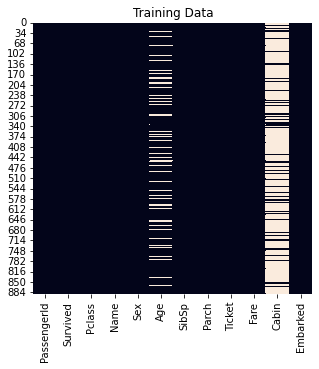

In [ ]:
plot_missing_data(train.isnull(),"Training Data")

In [40]:
# Since Cabin has 80 % missing data. No point in keepint it in the dataset. Lets drop it.
train.drop(['Cabin'],axis=1,inplace=True)

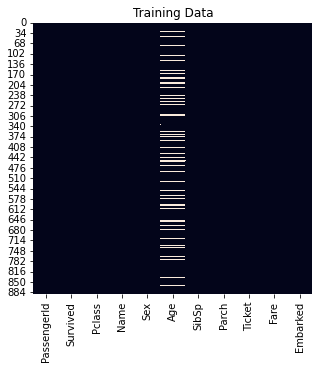

In [41]:
plot_missing_data(train.isnull(),"Training Data")

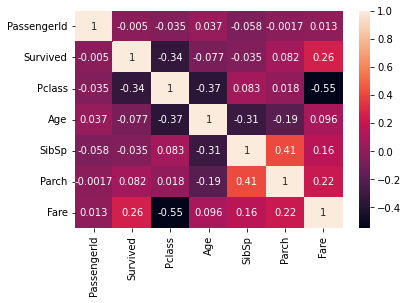

In [44]:
# LEts check correlation matric to find out which features are important in prediction survival

corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# We can see from the map that pclass and fare are highly correlated with survived. Lets analyse them further.

In [48]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [51]:
# Check fare*survived frequency

train.groupby(['Fare', 'Survived'])['Fare'].count().unstack()

Survived,0,1
Fare,,
0.0000,14.0,1.0
4.0125,1.0,NaN
5.0000,1.0,NaN
6.2375,1.0,NaN
6.4375,1.0,NaN
...,...,...
227.5250,1.0,3.0
247.5208,1.0,1.0
262.3750,NaN,2.0


In [52]:
# Check pclass*survived frequency

train.groupby(['Pclass', 'Survived'])['Pclass'].count().unstack()

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [62]:
# Check sex*survived frequency

train.groupby(['Sex', 'Survived'])['Sex'].count().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


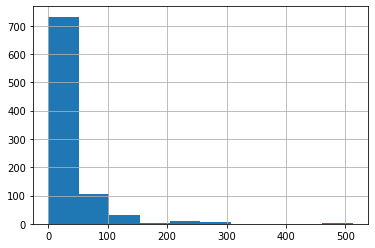

In [53]:
train['Fare'].hist()

In [58]:
scaler=MinMaxScaler()
train['Fare']=scaler.fit_transform(train[['Fare']])

In [61]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.014151,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,0.139136,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.015469,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,0.103644,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.015713,S


In [42]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# checking the missing values
train.isnull().sum()
#We can see that Age has 177 missing values out of 891. Thus we can do the missing values imputation. However, let’s leave it for the next advanced tutorial. For now, let’s not take the Age column. So for model input, we will have only Passenger class and Sex. The output is the Survived field.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
# lets onlytake two columns for ease in alaysis
train_x=train[["Pclass", "Sex","SibSp","Parch","Fare","Age"]]#Cabin","Embarked"]]
train_x.head()

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3,male,1,0,7.2500,22.0
1,1,female,1,0,71.2833,38.0
2,3,female,0,0,7.9250,26.0
3,1,female,1,0,53.1000,35.0
4,3,male,0,0,8.0500,35.0


In [ ]:
# Selecting output variable
train_y= train[["Survived"]]
train_y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
# Cleaning of the data
train_x["Sex"].replace("male",1,inplace=True)
train_x["Sex"].replace("female",0,inplace=True)
train_x.head()

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3,1,1,0,7.2500,22.0
1,1,0,1,0,71.2833,38.0
2,3,0,0,0,7.9250,26.0
3,1,0,1,0,53.1000,35.0
4,3,1,0,0,8.0500,35.0


In [ ]:
# Splitting dataset
tr_x, cv_x, tr_y, cv_y=train_test_split(train_x, train_y,test_size=0.2)
len(tr_x),len(cv_x),len(tr_y),len(cv_y)

(712, 179, 712, 179)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3b24e4a990>,
      dtype=object)

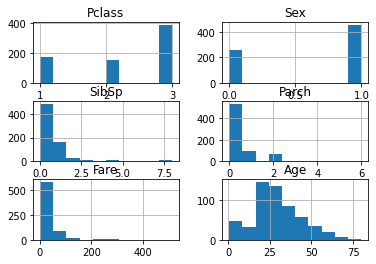

In [ ]:
tr_x.hist()

In [ ]:
#choose and train the model.
rf=RandomForestClassifier()


In [ ]:

#Fit the training and test data
rf.fit(tr_x,tr_y)

ValueError: ignored

In [ ]:
# Evaluate the model
accuracy_randomforest=rf.score(cv_x, cv_y)
print("Accuracy- {}%".format(accuracy_randomforest*100))

ValueError: ignored

In [ ]:
# Predict the data
test=pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
test_x=test[["Pclass", "Sex","SibSp","Parch","Fare","Age"]]
test_x.head()

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3,male,0,0,7.8292,34.5
1,3,female,1,0,7.0000,47.0
2,2,male,0,0,9.6875,62.0
3,3,male,0,0,8.6625,27.0
4,3,female,1,1,12.2875,22.0


In [ ]:
test_x["Sex"].replace("male",1,inplace=True)
test_x["Sex"].replace("female",0,inplace=True)
test_x.head()

,Pclass,Sex,SibSp,Parch,Fare,Age
0,3,1,0,0,7.8292,34.5
1,3,0,1,0,7.0000,47.0
2,2,1,0,0,9.6875,62.0
3,3,1,0,0,8.6625,27.0
4,3,0,1,1,12.2875,22.0


In [ ]:
prd=rf.predict(test_x)
prd

ValueError: ignored

In [ ]:
op=test[["PassengerId"]]
op['Survived']=prd
op.head()

NameError: ignored

In [ ]:
op.to_csv("Submission.csv", index=False)

In [ ]:
tr_x


,Pclass,Sex,SibSp,Parch,Fare,Age
172,3,0,1,1,11.1333,1.00
615,2,0,1,2,65.0000,24.00
342,2,1,0,0,13.0000,28.00
544,1,1,1,0,106.4250,50.00
817,2,1,1,1,37.0042,31.00
...,...,...,...,...,...,...
782,1,1,0,0,30.0000,29.00
831,2,1,1,1,18.7500,0.83
601,3,1,0,0,7.8958,NaN
411,3,1,0,0,6.8583,NaN


In [ ]:
#USe NN to predict survival rate

# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(60, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(40, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
 tf.keras.layers.Dense(20, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation 
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

# Fit the model
history = model_1.fit(tr_x, tr_y, epochs=50,validation_data=(cv_x, cv_y))
model_1.evaluate(tr_x,tr_y)

Epoch 1/50
23/23 [==============================] - 2s 24ms/step - loss: nan - accuracy: 0.6025 - val_loss: nan - val_accuracy: 0.6536
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 7/50
23/23 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.6067 - val_loss: nan - val_accuracy: 0.6536
Epoch 8/50
23/23 [==============================] - 0s 9ms

[nan, 0.6067415475845337]

In [ ]:
# Use logistic regression 
lgr=LogisticRegression()
lgr.fit(tr_x,tr_y)

ValueError: ignored

In [ ]:
accuracy=lgr.score(cv_x,cv_y)
print("Accuracy ={}%".format(accuracy*100))

ValueError: ignored

In [ ]:
# Predict for logistic regression
prl=lgr.predict(test_x)
prl

ValueError: ignored

In [ ]:
op2=test[['PassengerId']]
op2['Survived']=prl
op2.head()

NameError: ignored

In [ ]:
op2.to_csv("Submission2.csv",index=False)

In [ ]:
# Check accuracy against all other binary classifiers
models = {}
# Logistic regression

from sklearn.linear_model import LogisticRegression
models['Logistic Regression']=LogisticRegression(solver='lbfgs', max_iter=3000)

# Support vector machines
from sklearn.svm import LinearSVC
models['Support Vector Machines']=LinearSVC(max_iter=3000)

#Decision trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees']=DecisionTreeClassifier()

# Random forest 
from sklearn.ensemble import RandomForestClassifier
models['Random Forest']=RandomForestClassifier()

# Naive bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes']= GaussianNB()

#k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
models['k-neares neighbors']=KNeighborsClassifier()

#Extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
models['Extra tree Classifier'] = ExtraTreesClassifier()
#Light GBM 
from lightgbm import LGBMClassifier
#from lightgbm import log_evaluation, early_stopping
models['Light GBM Classifier'] = LGBMClassifier(objective='binary',
                     learning_rate=0.01,
                     num_iterations=700,
                     max_depth=7)

In [ ]:
## Import metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall ={}, {},{}

for key in models.keys():
  # Fit the model
  models[key].fit(tr_x, tr_y)

  # Prediction 
  prediction=models[key].predict(cv_x)

  # Calculate metrics
  accuracy[key]=accuracy_score(prediction,cv_y)
  precision[key]=precision_score(prediction,cv_y)
  recall[key]=recall_score(prediction, cv_y)

ValueError: ignored

In [ ]:
import pandas as pd
df_model = pd.DataFrame(index=models.keys(),columns=['Accuracy','Precision','Recall'])
df_model['Accuracy']=accuracy.values()
df_model['Precision']=precision.values()
df_model['Recall']=recall.values()

df_model

ValueError: ignored